## Problem: Visualizing and Summarizing Email Content

In this problem, we will use a variety of tools to visualize and identify similarities in emails.  We will consider textual data from emails sent from employees at Enron. Enron was the sixth largest energy company in the world, before they collasped and the majority of their executives were tried for fraud after overstating the company's earnings by several hundred million dollars.  This dataset is often used by researchers who are interested in "improving current email tools, or understanding how email is currently used" because "it is the only substantial collection of "real" email that is public" (https://www.cs.cmu.edu/~enron/). 

 #### Data Description:
The format of the enron_sample.txt file is: 

---
docID wordID count  
docID wordID count   
...  
docID wordID count   
docID wordID count  

---

There are 1000 documents (emails) in this sample.  Individual document names (i.e. a identifier for each docID) are not provided for copyright reasons. 

The format of the enron_sample_vocab.txt file is wordID = n.  That is, if "apple" is the first word in the vocab.enron.txt file, then the wordID for "apple" is 0.  

We have done much of the necessary pre-processing of this data to save you time.  Please run the code below to load the data.  The enron_sample.txt and enron_sample_vocab.txt files should be in the same folder as your notebook.  The code should run in about 1 minute.

In [1]:
%%time
#Import and pre-process the data
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#Read in the sparse matrix representation of the document-word count matrix
enron_file = open("enron_sample.txt", "r") 
enron_file = enron_file.readlines()

all_doc_ids = []
all_word_ids = []
all_counts = []
for l in range(0,len(enron_file)):
    l_text = enron_file[l].rstrip()
    [l_doc, l_word, l_count] = l_text.split(",")
    l_doc = int(l_doc) 
    l_word = int(l_word) 
    all_doc_ids.append(l_doc)
    all_word_ids.append(l_word)
    all_counts.append(int(l_count))
row = np.array(all_doc_ids)
col = np.array(all_word_ids)
counts = np.array(all_counts)  

num_documents = len(set(all_doc_ids))
num_words = len(set(all_word_ids))

#Convert to a dense document-word count matrix where the (ith, jth) entry gives the count of the jth word in the ith document
import scipy.sparse
X = scipy.sparse.csc_matrix((counts, (row,col)),shape=(num_documents,num_words))
X_dense = X.todense()

#Read in the word names  
word_names = open("enron_vocab_sample.txt", "r")
word_names = word_names.readlines()
word_names = [word_names[x] for x in range(0,num_words)]
word_names = [x.rstrip() for x in word_names]

Wall time: 8.68 s


In [2]:
%%time
#Import and pre-process the data
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#Read in the sparse matrix representation of the document-word count matrix
enron_file = open("enron_sample.txt", "r") 
enron_file = enron_file.readlines()

all_doc_ids = []
all_word_ids = []
all_counts = []
for l in range(0,len(enron_file)):
    l_text = enron_file[l].rstrip()
    [l_doc, l_word, l_count] = l_text.split(",")
    l_doc = int(l_doc) 
    l_word = int(l_word) 
    all_doc_ids.append(l_doc)
    all_word_ids.append(l_word)
    all_counts.append(int(l_count))
row = np.array(all_doc_ids)
col = np.array(all_word_ids)
counts = np.array(all_counts)  

num_documents = len(set(all_doc_ids))
num_words = len(set(all_word_ids))

#Convert to a dense document-word count matrix where the (ith, jth) entry gives the count of the jth word in the ith document
import scipy.sparse
X = scipy.sparse.csc_matrix((counts, (row,col)),shape=(num_documents,num_words))
X_dense = X.todense()

#Read in the word names  
word_names = open("enron_vocab_sample.txt", "r")
word_names = word_names.readlines()
word_names = [word_names[x] for x in range(0,num_words)]
word_names = [x.rstrip() for x in word_names]

Wall time: 257 ms


### Part A
Please report the 10 most common words in the corpus.  To do this, count the number of times
each word appears in the corpus and build a frequency table. 
(In particular, use counts as the "frequency"--do not divide by the total number of words in the corpus.)
Sort the table and print the top 10 most frequent words, along with their frequencies and ranks.  

Hint: You do not need to load nlp for this question.  Our code for this question ran in less than 10 seconds.

In [3]:
%%time
#Get counts
word_counts_unsorted_raw = np.sum(X_dense, axis=0)
word_counts_unsorted = word_counts_unsorted_raw.tolist()[0]

# compute the indices that would sort the list `word_counts_unsorted` in decreasing order (which is why there's a "::-1")
word_count_sort_indices = np.argsort(word_counts_unsorted)[::-1]

print('Rank'.ljust(5), 'Word'.ljust(10), 'Count')
for rank, idx in enumerate(word_count_sort_indices[:10]):
    print(str(rank + 1).ljust(5), word_names[idx].ljust(10), word_counts_unsorted[idx])

Rank  Word       Count
1     company    936
2     power      924
3     energy     578
4     market     571
5     california 540
6     business   462
7     firm       443
8     plan       431
9     group      413
10    price      411
Wall time: 18 ms


### Part B
Now, use the `TfidfTransformer` class in `scikit-learn` to transform this data.  Then, use the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the transformed sample data.  Use 10 max iterations, set `n_jobs=-1` to use all cores on your machine (if it helps). Please set the random_state to 95865 when running LDA. Print the top 5 words associated with each topic.  

Our code ran in less than 2 minutes for this section.   

In [4]:
%%time

#Create tf-idf matrix
from sklearn.feature_extraction.text import TfidfTransformer
X_tfidf = TfidfTransformer().fit_transform(X_dense)

#Learn LDA model
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10,
                                learning_method='online',
                                n_jobs=-1, random_state=95865)
lda.fit(X_tfidf)

#Print top words associated with each topic
n_top_words = 5
feature_names = word_names
most_probable_words = []
for topic_idx, topic in enumerate(lda.components_):
    message = "Topic #%d: " % topic_idx
    message += "\n\t"
    message += "\n\t".join([feature_names[i]
                            for i in topic.argsort()[:-n_top_words-1:-1]])
    most_probable_words.append("\n\t".join([feature_names[i]
                                           for i in topic.argsort()[:-n_top_words-1:-1]]))
    print(message)
    print() 

Topic #0: 
	buycom
	price
	meeting
	subcommittee
	floor

Topic #1: 
	meeting
	attached
	power
	market
	team

Topic #2: 
	think
	item
	tomorrow
	release
	brian

Topic #3: 
	nbsk
	foex
	lincoln
	kazakhstan
	bhkp

Topic #4: 
	status
	amount
	report
	changed
	expense

Topic #5: 
	game
	bass
	fantasy
	longhorn
	msn

Topic #6: 
	imageimage
	bikes
	imageimageimage
	unsolicited
	opt

Topic #7: 
	hourahead
	final
	variances
	detected
	parsing

Topic #8: 
	lawyer
	monitor
	attaching
	unit
	profit

Topic #9: 
	clothes
	accessories
	loving
	skiing
	polite

Wall time: 23.2 s


### Part C
Please write a few sentences to interpret the results of your topic modeling.  What do the various clusters seem to represent? 
Do they appear to be meaningful email categories for an energy company?

#### Here, please write your interpretation: Topic 1 and Topic 7's highest probability words might be related to trading and finance.  Topic 5 and Topic 9's distribution over words might reflect recreational activities.  Topic 2 and Topic 4's highest probability words might be related to logistical activities, like meetings.  While few of the topics explictly deal with oil or energy, these topics do reflect reasonable subjects to be discussed in a company.  


### Part D
Please use t-SNE and the probability distribution of documents over topics to find a 2-D representation of the email documents. 
That is, please run t-SNE on the documents' distributions over topics, which is an output of your LDA model. When running t-SNE, set the angle to 0.5, the learning rate to 800, and init to 'PCA'.

Our code ran in less than 30 seconds for this section.

In [5]:
%%time
#Find 2D represenation of the email documents
topic_proportions = lda.transform(X_tfidf)
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, learning_rate=800, 
                  verbose=1, random_state=0, angle=.5, init='pca')

# 20-D -> 2-D
topic_tsne_lda = tsne_model.fit_transform(topic_proportions)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.002453
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.764156
[t-SNE] Error after 1000 iterations: 0.186362
Wall time: 22.1 s


### Part E
Use DP means to pick the number of clusters in your 2-D representation, assuming that you are only interested in clusters with probability of at least .05. Set the number of mixture components to 20, the weight concentration prior to .1, n_init to 200, and the random state to 95865.

Our code for this section ran in less than 2 minutes.

In [6]:
%%time
#Determine the number of clusters
from sklearn.mixture import BayesianGaussianMixture

dpgmm = BayesianGaussianMixture(n_components=20, weight_concentration_prior=.1, n_init=200, random_state=95865)
dpgmm.fit(topic_tsne_lda)

print(np.sort(dpgmm.weights_)[::-1])

[  1.84753964e-01   1.81413690e-01   1.46336359e-01   1.45074380e-01
   1.43568760e-01   1.26974192e-01   7.07523908e-02   1.07372863e-03
   4.77600207e-05   4.34181905e-06   3.94710823e-07   3.58828021e-08
   3.26207292e-09   2.96552083e-10   2.69592803e-11   2.45084366e-12
   2.22803969e-13   2.02549063e-14   1.84135512e-15   1.67395920e-16]
Wall time: 1min 34s


#### Here, please write your choice for the number of clusters given your DP-Means results:  There are 7 clusters with probability of at least .05, so we select 7 clusters given these results.


### Part F
Fit a GMM model with the number of clusters found in part E and visualize the clustering results in a scatter plot. Each document should be represented by its 2-D t-SNE representation and should be color coded according to it's clustering assignment. When running your GMM, set n_init to 200, and the random_state to 95865.

Our code for this section ran in less than 10 seconds.

[ 0.17899959  0.15947994  0.13788893  0.13552729  0.13252308  0.12786762
  0.12771354]
Wall time: 7.81 s


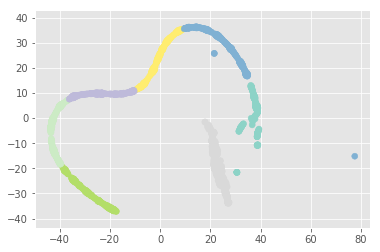

In [7]:
%%time
#Fitting GMM with Number of Clusters Determined By DP-Means
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=7, n_init=200, random_state=95865)
gmm.fit(topic_tsne_lda)

print(np.sort(gmm.weights_)[::-1])

gmm_cluster_assignments = gmm.predict(topic_tsne_lda)
plt.scatter(topic_tsne_lda[:, 0], topic_tsne_lda[:, 1], c=gmm_cluster_assignments, cmap='Set3')
plt.axis('equal')

### Part G
Now use sklearn's built-in CH-index function to pick the number of clusters. Here, you should use a for loop to run k-means for values of k = [2, 5, 10, 20, 30] over your 2-D t-SNE representation of the data.  When running k-means, set n_init to 1000 and random_state to 95865. Please record the CH-index for each k, and plot the results.  Indicate if you would select k to be 2, 5, 10, 20, or 30 given these results. 

Our code for this section ran in under 1 minute 30 seconds.

Wall time: 37.7 s


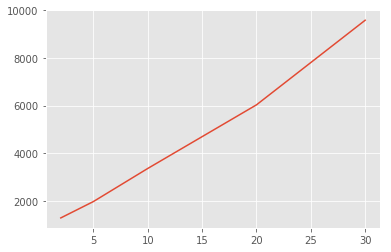

In [8]:
%%time
#Determine Number of Clusters with k-means and CH-Index
from sklearn.cluster import KMeans
from sklearn import metrics

ch_index_scores = []
k_list = [2, 5,10,20,30]
for k in k_list:
    kmeans = KMeans(n_clusters=k, n_init=1000, random_state=95865)
    kmeans.fit(topic_tsne_lda)
    labels = kmeans.labels_
    chi = metrics.calinski_harabaz_score(topic_tsne_lda, labels)
    ch_index_scores.append(chi)
    
plt.plot(k_list, ch_index_scores)

#### Here, please write your choice for the number of clusters based on your analysis using k-means and the CH-Index: 30


### Part H
Fit k-means with the number of clusters found in part G and visualize the clustering results in a scatter plot. 
Each document should be represented by its 2-D t-SNE representation and should be color coded according to it's clustering assignment.

Then, write a few sentences explaining your results from part E and from this clustering visualization.  Are the clusters found by k-means good? Why might you have gotten these results?  

Wall time: 14.2 s


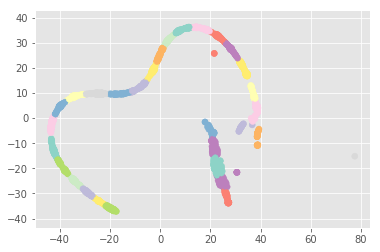

In [9]:
%%time
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=30, n_init=1000, random_state=95865)
kmeans.fit(topic_tsne_lda)

kmeans_cluster_assignments = kmeans.predict(topic_tsne_lda)

plt.scatter(topic_tsne_lda[:, 0], topic_tsne_lda[:, 1],
            c=kmeans_cluster_assignments, cmap='Set3')
plt.axis('equal')

#### Here, please write a few sentences to explain your results:  The CH-Index was increasing with the number of clusters for these values of k.  We therefore selected k = 30.  The clusters do not appear to be very good.  K-means shouldn't be expected to work well for this dataset as it doesn't remember a bunch of circle-shaped clusters, which might explain these results.
